# Experiment result:

|  | 0 | 1/3 | 1/2 | 2/3 | 1 |
|-------------------|--------|--------|---------|-----|-------|
| pre-trained model | 0.7462 | 0.6069 | 0.45465 | 0.26025 | 0.041 |
| fine tuned on 0 | 0.9159 |  |  |  |  |
| fine tuned on 1/3 |  |  |  |  |  |
| fine tuned on 1/2 |  |  |  |  |  |
| fine tuned on 2/3 |  |  |  |  |  |
| fine tuned on all |  |  |  |  |  |

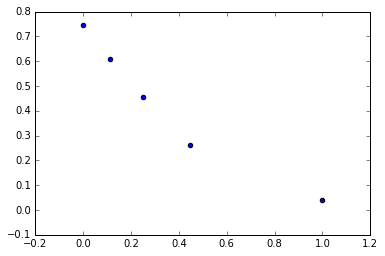

In [13]:
# Result visualization.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = [0, 1.0/3, 1.0/2, 2.0/3, 1]
xx = [t * t for t in x]
y = [0.7462, 0.6069, 0.45465, 0.26025, 0.041]

plt.scatter(xx, y)

In [6]:
# Data cleaning.
'''
Some constants:

synset_names = ['n01855672', 'n02009912', 'n02051845', 'n02398521', 'n03017168',\
'n03028079', 'n03109150', 'n03160309', 'n03179701', 'n03759954', 'n03770679', \
'n03983396', 'n04086273', 'n04372370', 'n04392985', 'n04584207', 'n07720875', \
'n02504458', 'n02276258', 'n01944390']

new_to_original_class_id = [99, 113, 132, 144, 321, 344, 386, 494, 497, 512, 525, 526, \
650, 656, 737, 763, 844, 848, 903, 945]

original_to_new_class_id = {512: 9, 321: 4, 386: 6, 99: 0, 132: 2, 848: 17, 497: 8,\
650: 12, 903: 18, 844: 16, 525: 10, 494: 7, 144: 3, 113: 1, 763: 15, 526: 11, 344: 5,\
656: 13, 737: 14, 945: 19}

'''

import os

imagenet_root = '/home/haow3/occlusion-project/data/imagenet/'
caffe_root = '/home/haow3/software/caffe-rc3/'

original_to_new_class_id = {512: 9, 321: 4, 386: 6, 99: 0, 132: 2, 848: 17, 497: 8,\
650: 12, 903: 18, 844: 16, 525: 10, 494: 7, 144: 3, 113: 1, 763: 15, 526: 11, 344: 5,\
656: 13, 737: 14, 945: 19}

for filename in os.listdir(imagenet_root + 'dataset/list_original_id/'):
    if filename.find('.txt') == -1:
        continue
    print 'Processing: ', filename
    
    fin = open(imagenet_root + 'dataset/list_original_id/' + filename, 'r')
    fout = open(imagenet_root + 'dataset/' + filename, 'w')
    
    lines = fin.readlines()
    for line in lines:
        filepath, class_id = line.split(' ')
        fout.write('{} {}\n'.format(filepath, original_to_new_class_id[int(class_id)]))
        
    fin.close()
    fout.close()

Processing:  test_11_3.txt
Processing:  test_25_3.txt
Processing:  train_100_1.txt
Processing:  test_0_0.txt
Processing:  test_100_1.txt
Processing:  test_44_2.txt
Processing:  train_0_0.txt
Processing:  train_11_3.txt
Processing:  train_25_3.txt
Processing:  train_44_2.txt


In [ ]:
# Test.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import caffe
import sys


imagenet_root = '/home/haow3/occlusion-project/data/imagenet/'
caffe_root = '/home/haow3/software/caffe-rc3/'
new_to_original_class_id = [99, 113, 132, 144, 321, 344, 386, 494, 497, 512, 525, 526, \
650, 656, 737, 763, 844, 848, 903, 945]
original_to_new_class_id = {512: 9, 321: 4, 386: 6, 99: 0, 132: 2, 848: 17, 497: 8,\
650: 12, 903: 18, 844: 16, 525: 10, 494: 7, 144: 3, 113: 1, 763: 15, 526: 11, 344: 5,\
656: 13, 737: 14, 945: 19}

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

caffe.set_device(0)
caffe.set_mode_gpu()
is_finetuned = True

#net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
#                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
#                caffe.TEST)
net = caffe.Net(imagenet_root + 'model/finetune_caffenet_0/deploy.prototxt',
                imagenet_root + 'model/finetune_caffenet_0/finetune_caffenet_0.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

# set net to batch size of 50
net.blobs['data'].reshape(50,3,227,227)

test_dataset = [(0.0, 0), (1.0/3, 3), (1.0/2, 3), (2.0/3, 2), (1.0, 1)]
#test_dataset = [(0.0, 0)]
positive_true = [0 for i in test_dataset]
image_sum = [0 for i in test_dataset]
accuracy = [0.0 for i in test_dataset]

for index, (occlu_size, occlu_num) in enumerate(test_dataset):
    percent = str(int(100 * occlu_size * occlu_size))
    print percent, occlu_num
    test_file = open('{}dataset/test_{}_{}.txt'.format(imagenet_root, percent, str(occlu_num)), 'r')
    
    lines = test_file.readlines()
    image_sum[index] = len(lines)
    for i, line in enumerate(lines):
        # A possible optimization to consider: add occluders on the test image before feeding them.
        image_path, class_id = line.split(' ')
        class_id = int(class_id)
        net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(image_path))
        out = net.forward()
        predict_id = out['prob'][0].argmax()
        if is_finetuned:
            true_id = class_id
        else:
            true_id = new_to_original_class_id[class_id]
        if i % 100 == 0:
            print '{}/{}: {} {} {}'.format(i, image_sum[index], image_path, predict_id, true_id)
        if true_id == predict_id:
            positive_true[index] += 1        
    accuracy[index] = positive_true[index] / float(image_sum[index])
    
    print 'positive_true: ', positive_true
    print 'image_sum: ', image_sum
    print 'accuracy: ', accuracy
    

0 0
0/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n01855672_13294_0.jpeg 0 0
100/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n02009912_4182_0.jpeg 2 2
200/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n02051845_331_0.jpeg 3 3
300/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n02398521_935_0.jpeg 5 5
400/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n03017168_2788_0.jpeg 13 7
500/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n03028079_14885_0.jpeg 8 8
600/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n03109150_26169_0.jpeg 9 9
700/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n03160309_11747_0.jpeg 10 10
800/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n03179701_22241_0.jpeg 17 11
900/2000: /home/haow3/occlusion-project/data/imagenet/dataset/test_0_0/n03759954_21940_0.jpeg 17 12
1000/2000: /home/